# Numerical method to do the reproduction

Reminder: use Ctrl+/ to add/cancel comment for whole cell

### import stuff

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm import tqdm
from scipy.constants import k as k_B, e

### Parameters define

In [28]:
# Tight-binding model parameters
a = 3.18
t1 = 146e-3
t2 = -0.40 * t1
t3 = 0.25 * t1
mu = 0

# Physical constants in convenient units
mu_B_eVT = 5.7883818012e-5  # Bohr magneton in eV/T
k_B_eV = k_B / e           # Boltzmann constant in eV/K

# Zeeman-type spin-splitting parameters (initial values)
alpha = 0
beta = 0

# Define the critical temperature and convert it to units of eV
Tc_K = 6.5
Tc_eV = k_B_eV * Tc_K

### Core code

This is the Fermi shell approxi version code. Basiclly give up sum over all k space version.

In [29]:
# energy dispersion, corresponding to H_{kin} term
def eps_Mo(kx, ky, mu):
    return (2*t1*(np.cos(ky*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a))
            +2*t2*(np.cos(np.sqrt(3)*kx*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(1.5*ky*a))
            +2*t3*(np.cos(2*ky*a) + 2*np.cos(np.sqrt(3)*kx*a)*np.cos(ky*a))-mu)

# g_z(k) for Zeeman-type SOI
def core_g(kx, ky):
    # sin(ky a) - 2 cos(√3/2 kx a) sin(ky a/2)
    return np.sin(ky*a) - 2*np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)

def f_k(kx, ky):
    # f(k) = | core_g(k) |
    return np.abs(core_g(kx, ky))

def F_k(kx, ky, fK, beta):
    # F(k) = beta * tanh[ f(K) - f(k) ] - 1
    return beta * np.tanh(fK - f_k(kx, ky)) - 1.0

def gzz(kx, ky, fK, beta):
    return F_k(kx, ky, fK, beta) * core_g(kx, ky)

# g_R(k) for Rashba-type SOI
def gR_core(kx, ky):
    gx_core = -np.sin(ky*a) - np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)
    gy_core = np.sqrt(3) * np.sin(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a)
    return gx_core, gy_core

def gR_vec(kx, ky, fK, beta):
    Fk = F_k(kx, ky, fK, beta)
    gx_core, gy_core = gR_core(kx, ky)
    return Fk * gx_core, Fk * gy_core

def gR_mag(kx, ky, fK, beta):
    gx, gy = gR_vec(kx, ky, fK, beta)
    return np.sqrt(gx*gx + gy*gy)

# High symmetry points
Gamma = np.array([0.0, 0.0])
K = np.array([0.0, 4*np.pi/(3*a)])
M = np.array([np.pi/(np.sqrt(3)*a), np.pi/a])

# Path, Γ←K (neg s) and K→M (pos s), near K
def path_around_K(smax=0.2, N=501):
    v_GK = K - Gamma
    v_KM = M - K
    L_GK = np.linalg.norm(v_GK)
    L_KM = np.linalg.norm(v_KM)

    u1 = np.linspace(1 - smax/L_GK, 1.0, N)   # Γ→K near K
    u2 = np.linspace(0.0, smax/L_KM, N)       # K→M near K

    k_GK = Gamma + u1[:,None]*v_GK
    k_KM = K     + u2[:,None]*v_KM

    s_GK = -(1.0 - u1) * L_GK    # [-smax, 0]
    s_KM =  (u2      ) * L_KM    # [ 0, +smax]

    kx = np.concatenate([k_GK[:,0], k_KM[:,0]])
    ky = np.concatenate([k_GK[:,1], k_KM[:,1]])
    s  = np.concatenate([s_GK,       s_KM])

    return kx, ky, s

kx, ky, s = path_around_K(smax=0.2, N=501)

# Align to E_F
mu_guess = 0.0
E_K_raw  = eps_Mo(K[0], K[1], mu_guess)     # Energy at K point with initial mu_guess
E_F      = E_K_raw + 0.15
E = lambda kx,ky: eps_Mo(kx,ky,mu_guess)-E_F

kx_l, ky_l, s_l = path_around_K(0.2, 301)
mask_R = s_l >= 0
kF_idx = np.argmin(np.abs(E(kx_l[mask_R], ky_l[mask_R])))
kF_kx, kF_ky = kx_l[mask_R][kF_idx], ky_l[mask_R][kF_idx]

# alpha and beta calibration
fK    = f_k(K[0], K[1])
coreK = abs(core_g(K[0], K[1]))
alpha = (3e-3) / (2.0*max(coreK,1e-18))

def beta_from_target(target_meV):
    betas = np.linspace(0.5, 200.0, 2001)
    spls  = np.array([2*alpha*abs(gzz(kF_kx, kF_ky, fK, b)) for b in betas])
    return float(betas[np.argmin(np.abs(spls - target_meV*1e-3))])

# ------------------------ Fermi shell ------------------------
# K and -K patches in k-space
def k_patch(center, rad=0.20, Nk=91):
    qx = np.linspace(-rad, rad, Nk)
    qy = np.linspace(-rad, rad, Nk)
    Qx, Qy = np.meshgrid(qx, qy, indexing='xy')
    mask = (Qx**2 + Qy**2 <= rad**2)
    kx = center[0] + Qx[mask]
    ky = center[1] + Qy[mask]
    return kx, ky

# Build Fermi surface shell samples around K and -K
def build_FS_shell(mu_guess, EF, rad=0.20, Nk=91, n_keep=1200):
    kxK,  kyK  = k_patch(K,   rad, Nk)
    kxKm, kyKm = k_patch(-K,  rad, Nk)
    xiK  = eps_Mo(kxK,  kyK,  mu_guess) - EF
    xiKm = eps_Mo(kxKm, kyKm, mu_guess) - EF
    idxK  = np.argsort(np.abs(xiK))[:n_keep]
    idxKm = np.argsort(np.abs(xiKm))[:n_keep]
    return (kxK[idxK], kyK[idxK]), (kxKm[idxKm], kyKm[idxKm])

# ------------------------ Susceptibility calculation ------------------------
# 2x2 identity and Pauli matrices
I2 = np.eye(2, dtype=complex)
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sz = np.array([[1, 0],[0,-1]], dtype=complex)

# k grid setup
Nk = 121
kx_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
ky_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
# Precompute k-grid and dispersion once
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing='xy')
eps_grid_global = eps_Mo(kx_grid, ky_grid, mu)

# Encapsulated as g_z(kx, ky) without additional parameters
gz_func = lambda kx, ky: gzz(kx, ky, fK, beta)

# calculate χ using the formula with vectorization over k-grid
def chi_singlet_vectorized(T, H, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):

    # K-point k-grid
    kxK,  kyK  = kK

    # Energy at k
    EK   = eps_Mo(kxK,  kyK,  mu_guess) - EF

    # Zeeman-type component DeltaZ at k
    DeltaZ_K  = alpha_Z * gz_func(kxK,  kyK)

    # Rashba components g_Rx, g_Ry at k
    gRxK, gRyK   = gR_func(kxK,  kyK)

    # Matsubara frequencies
    wn = (2*np.arange(Nw)+1) * np.pi * k_B_eV * T

    # use [:, None] and [None, :] to vectorize over k and omega_n. (broadcasting)
    A1   = 1j*wn[:,None] - EK[None,:]    # G(k, i omega_n)
    
    # Using symmetry properties: eps(-k) = eps(k)
    A2  = -1j*wn[:,None] - EK[None,:]   # G(-k, -i omega_n)

    # 3 components of effective field B at K
    Bx  = (-mu_B_eVT * H) + alpha_R * gRxK[None,:]      # B_x = -mu_B*H + alpha_R * g_Rx(k)
    By  = (alpha_R * gRyK)[None,:]                      # B_y = alpha_R * g_Ry(k)
    Bz  = (-DeltaZ_K)[None,:]                           # B_z = -Delta_Z(k)

    # 3 components of effective field B at -k (using symmetry properties)
    # Bx2: gRx(-k) = -gRx(k) (odd function)
    Bx2 = (-mu_B_eVT * H) - alpha_R * gRxK[None,:]
    # By2: gRy(-k) = gRy(k) (even function)
    By2 = (alpha_R * gRyK)[None,:]
    # Bz2: DeltaZ(-k) = -DeltaZ(k) (odd function)
    Bz2 = -(-DeltaZ_K)[None,:]

    # 2×2 green's function elements G(k, i omega_n)
    denominator1  = (A1*A1  - Bx*Bx  - By*By  - Bz*Bz)
    Guu    = (A1 - Bz)/denominator1
    Gdd    = (A1 + Bz)/denominator1
    Gud    = (Bx - 1j*By)/denominator1
    Gdu    = (Bx + 1j*By)/denominator1

    # 2×2 green's function elements G(-k, -i omega_n)
    denominator2 = (A2*A2 - Bx2*Bx2 - By2*By2 - Bz2*Bz2)
    Guu_m  = (A2 - Bz2)/denominator2
    Gdd_m  = (A2 + Bz2)/denominator2
    Gud_m  = (Bx2 - 1j*By2)/denominator2
    Gdu_m  = (Bx2 + 1j*By2)/denominator2

    # singlet pairing susceptibility
    term = Guu*Gdd_m - Gdu*Gud_m
    chi  = (k_B_eV*T) * np.real(term.sum()) / kxK.size
    return float(chi)

# find V from Tc at H=0
def determine_V(Tc, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):
    chi_Tc0 = chi_singlet_vectorized(Tc, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    return 1.0 / chi_Tc0


### Find $H_c2(T)$ for 13meV and 3meV with fixed Rashba

In [30]:
# # ------------------------ Find Hc2 ----------------------------
# # Find Hc2 at given T using bisection method searching in [0, Hmax]
# def find_Hc2(T, V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Hmax=100.0):
#     if V*chi_singlet_vectorized(T, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw) < 1.0:
#         return 0.0
#     lo, hi = 0.0, Hmax
#     for _ in range(24):
#         mid = 0.5*(lo+hi)
#         v   = V*chi_singlet_vectorized(T, mid, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
#         if v >= 1.0: lo = mid
#         else:        hi = mid
#     return 0.5*(lo+hi)

# # ------------------------ two curves ----------------------------
# # Fix alpha = 3, Do beta recalibration for each curve to make Δ(k_F)=13/3 meV
# kK, _ = build_FS_shell(mu_guess, E_F, n_keep=1200)
# print("FS sample per valley:", kK[0].size)

# Tc = 6.5    # critical temperature in K
# Ts = np.linspace(0.1, 7.0, 100)
# Nw = 800    # how many Matsubara frequencies considered
# targets = [13.0, 3.0]
# labels  = [r'(Delta=13meV)', r'(Delta=3meV)']

# RASHBA_RATIO = 0.1

# plt.figure(figsize=(6,4.6))
# # Loop over target splittings
# for targ, lab in zip(targets, labels):
#     beta   = beta_from_target(targ)
#     gz_fun = lambda kx,ky, fK=fK, b=beta: gzz(kx,ky,fK,b)

#     gR_fun = lambda kx,ky, fK=fK, b=beta: gR_vec(kx,ky,fK,b)
#     alpha_R = RASHBA_RATIO * alpha 

#     # use Tc at H=0 to calibrate V
#     V = determine_V(Tc, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F, Nw)

#     # progress bar over temperatures
#     Hs = [find_Hc2(T, V, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F,
#                    Nw, Hmax=100.0)
#           for T in tqdm(Ts, desc=f'Hc2 {lab}')]
    
#     # plot with different colors
#     if targ == 13.0:
#         plt.plot(Ts, Hs, lw=2.2, color='red', label=lab)
#     else:
#         plt.plot(Ts, Hs, lw=2.2, color='black', label=lab)

# plt.xlabel('T (K)')
# plt.ylabel(r'$\mu_0 H_{c2}$ (T)')
# plt.xlim(0, 7.0); plt.ylim(0, 80)
# plt.grid(True, ls=':'); plt.legend()
# plt.tight_layout()
# plt.title('Temperature dependence of upper critical field')
# plt.show()

### Find $H_c2(T)$ for 13meV with multi Rashba

FS sample per valley: 1200


Hc2 eta=0.7: 100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


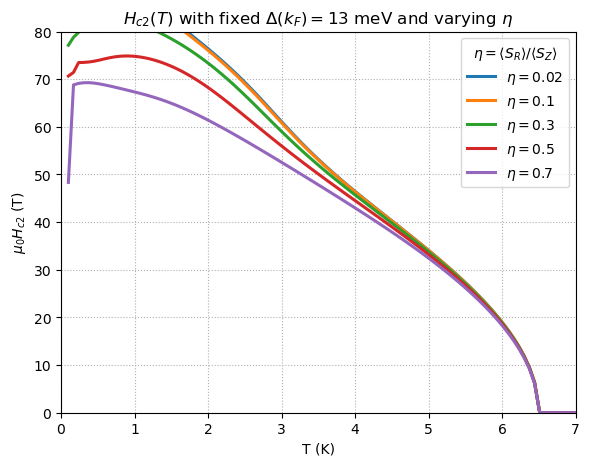

In [31]:
# ------------------------ Find Hc2 ----------------------------
# Find Hc2 at given T using bisection method searching in [0, Hmax]
def find_Hc2(T, V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Hmax=100.0):
    if V*chi_singlet_vectorized(T, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw) < 1.0:
        return 0.0
    lo, hi = 0.0, Hmax
    for _ in range(24):
        mid = 0.5*(lo+hi)
        v   = V*chi_singlet_vectorized(T, mid, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0: lo = mid
        else:        hi = mid
    return 0.5*(lo+hi)

# ------------------------ Curves with multiple eta ----------------------------
# Delta = 13 meV with varity η = <S_R>/<S_Z>
kK, _ = build_FS_shell(mu_guess, E_F, n_keep=1200)
print("FS sample per valley:", kK[0].size)

Tc = 6.5
Ts = np.linspace(0.1, 7.0, 100)
Nw = 800

# target spin splitting fixed at 13 meV
targ = 13.0
beta = beta_from_target(targ)

# g-vectors
gz_fun = lambda kx, ky, fK=fK, b=beta: gzz(kx, ky, fK, b)
gR_fun = lambda kx, ky, fK=fK, b=beta: gR_vec(kx, ky, fK, b)

# set of η values
# eta_list = [0.00, 0.02, 0.06, 0.10]
eta_list = [0.02, 0.1, 0.3, 0.5, 0.7]

plt.figure(figsize=(6,4.6))
for eta in eta_list:
    alpha_R = eta * alpha  

    # use Tc at H=0 to calibrate V
    V = determine_V(Tc, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F, Nw)

    # progress bar
    Hs = [find_Hc2(T, V, alpha, alpha_R, gz_fun, gR_fun, kK, mu_guess, E_F,
                   Nw, Hmax=100.0)
          for T in tqdm(Ts, desc=f'Hc2 eta={eta:.2g}')]

    plt.plot(Ts, Hs, lw=2.2, label=rf'$\eta={eta:.2g}$')

plt.xlabel('T (K)')
plt.ylabel(r'$\mu_0 H_{c2}$ (T)')
plt.xlim(0, 7.0); plt.ylim(0, 80)
plt.grid(True, ls=':')
plt.legend(title=r'$\eta=\langle S_R\rangle/\langle S_Z\rangle$')
plt.tight_layout()
plt.title(r'$H_{c2}(T)$ with fixed $\Delta(k_F)=13$ meV and varying $\eta$')
plt.show()


### Find $T_c(\mu)$ for fix $V$ and magnetic field = 0

Calibrating fixed V...
FS sample per valley (for V calibration): 1200
Building FS shell at calibration point EF_center = -0.7479 eV
FS sample per valley (for V calibration): 1200
Starting Tc(mu) calculation for eta list: [0.02, 0.1, 0.3, 0.5, 0.7]

--- Processing eta = 0.02 ---
  Calibrated V = 0.018746 for eta = 0.02


  Scanning E_F (eta=0.02): 100%|██████████| 51/51 [01:07<00:00,  1.33s/it]



--- Processing eta = 0.10 ---
  Calibrated V = 0.018749 for eta = 0.10


  Scanning E_F (eta=0.10): 100%|██████████| 51/51 [01:02<00:00,  1.23s/it]



--- Processing eta = 0.30 ---
  Calibrated V = 0.018768 for eta = 0.30


  Scanning E_F (eta=0.30): 100%|██████████| 51/51 [01:00<00:00,  1.19s/it]



--- Processing eta = 0.50 ---
  Calibrated V = 0.018806 for eta = 0.50


  Scanning E_F (eta=0.50): 100%|██████████| 51/51 [00:55<00:00,  1.08s/it]



--- Processing eta = 0.70 ---
  Calibrated V = 0.018862 for eta = 0.70


  Scanning E_F (eta=0.70): 100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


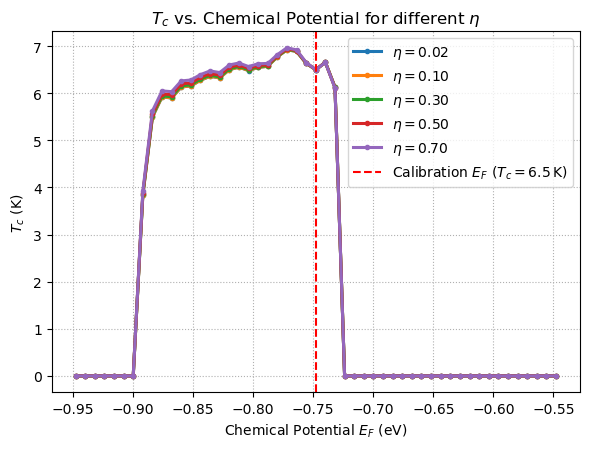


--- All calculations complete ---


In [25]:
# ------------------------ Find Tc ----------------------------
# Find Tc at given H=0 using bisection method searching in [Tmin, Tmax]
def find_Tc(V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Tmax=20.0, Tmin=0.01):
    # Check if it's superconducting at all (at T_min)
    # H=0.0
    chi_minT = chi_singlet_vectorized(Tmin, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_minT < 1.0:
        return 0.0  # Not superconducting

    # Check if it's normal at Tmax
    # H=0.0
    chi_maxT = chi_singlet_vectorized(Tmax, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_maxT > 1.0:
        print(f"Warning: Still superconducting at Tmax={Tmax}K for EF={EF}. Increase Tmax.")
        return Tmax

    lo, hi = Tmin, Tmax
    for _ in range(24): # Bisection search
        mid = 0.5 * (lo + hi)
        # H=0.0
        v = V * chi_singlet_vectorized(mid, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0:  # Superconducting phase (T < Tc)
            lo = mid
        else:         # Normal phase (T > Tc)
            hi = mid
    return 0.5 * (lo + hi)


# ------------------------ Calculate Tc(mu) for fixed V ------------------------
# We use the parameters from the first curve (target_meV = 13.0) to fix V
print("Calibrating fixed V...")
target_meV_for_V = 13.0
beta_for_V = beta_from_target(target_meV_for_V)

gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gR_vec(kx, ky, fK, b)

Tc_initial = 6.5  # K
Nw = 800          # Matsubara frequencies
n_keep = 1200     # FS sample size per valley

# The Zeeman-type coupling strength is fixed
alpha_Z_fixed = alpha

# Build FS shell for the *original* E_F to calibrate V
kK_initial, kKm_initial = build_FS_shell(mu_guess, E_F, n_keep=n_keep)
print(f"FS sample per valley (for V calibration): {kK_initial[0].size}")

# The original E_F is the center
EF_center = E_F
EF_scan_range = 0.2 # scan range in eV
N_mu_points = 51
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)

# range of eta values
# eta_list = [0.00, 0.02, 0.06, 0.10] 
eta_list = [0.02, 0.1, 0.3, 0.5, 0.7]

print(f"Building FS shell at calibration point EF_center = {EF_center:.4f} eV")
kK_calib, kKm_calib = build_FS_shell(mu_guess, EF_center, n_keep=n_keep)
print(f"FS sample per valley (for V calibration): {kK_calib[0].size}")

# Prepare the plot
plt.figure(figsize=(6, 4.6))

# Loop over eta values
print(f"Starting Tc(mu) calculation for eta list: {eta_list}")

for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    # set the Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed
    
    # calibrate V for eta in this loop
    # This V ensures that Tc(EF_center) = Tc_initial for this eta
    V_calibrated = determine_V(Tc_initial, alpha_Z_fixed, alpha_R_current,
                               gz_fun_fixed, gR_fun_fixed,
                               kK_calib, mu_guess, EF_center, Nw)
    
    print(f"  Calibrated V = {V_calibrated:.6f} for eta = {eta:.2f}")

    # prepare list to store results for this eta's curve
    Tc_results_for_this_eta = []

    # scan over the E_F range using this calibrated V
    desc = f"  Scanning E_F (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        
        # Re-build FS shell for the *current* chemical potential EF_val
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, n_keep=n_keep)
        
        # Find Tc using the V calibrated for this eta
        Tc_new = find_Tc(V_calibrated, alpha_Z_fixed, alpha_R_current,
                         gz_fun_fixed, gR_fun_fixed,
                         kK_new, mu_guess, EF_val, Nw, Tmax=20.0)
        
        Tc_results_for_this_eta.append(Tc_new)

    # Plot
    plt.plot(EF_range, Tc_results_for_this_eta, lw=2.2, 
             marker='o', markersize=3, 
             label=rf'$\eta={eta:.2f}$')

# Finalize and show the plot
plt.xlabel(r'Chemical Potential $E_F$ (eV)')
plt.ylabel(r'$T_c$ (K)')
plt.title(r'$T_c$ vs. Chemical Potential for different $\eta$')
# Add a vertical line at the E_F used for V calibration
plt.axvline(EF_center, color='red', ls='--', 
            label=f'Calibration $E_F$ ($T_c={Tc_initial}\,$K)')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- All calculations complete ---")

### Find $V(\mu)$ for fix $T_c$ and magnetic field = 0

Using fixed Tc = 6.5 K
Using fixed SOI g-function shapes for target_meV = 13.0
Scanning mu (E_F) from -0.948 eV to -0.548 eV

--- Processing eta = 0.02 ---


  Scanning V(mu) (eta=0.02):   0%|          | 0/51 [00:00<?, ?it/s]

  Scanning V(mu) (eta=0.02): 100%|██████████| 51/51 [00:05<00:00,  9.94it/s]



--- Processing eta = 0.10 ---


  Scanning V(mu) (eta=0.10): 100%|██████████| 51/51 [00:05<00:00,  9.62it/s]



--- Processing eta = 0.30 ---


  Scanning V(mu) (eta=0.30): 100%|██████████| 51/51 [00:05<00:00,  9.69it/s]



--- Processing eta = 0.50 ---


  Scanning V(mu) (eta=0.50): 100%|██████████| 51/51 [00:05<00:00, 10.16it/s]



--- Processing eta = 0.70 ---


  Scanning V(mu) (eta=0.70): 100%|██████████| 51/51 [00:05<00:00, 10.12it/s]


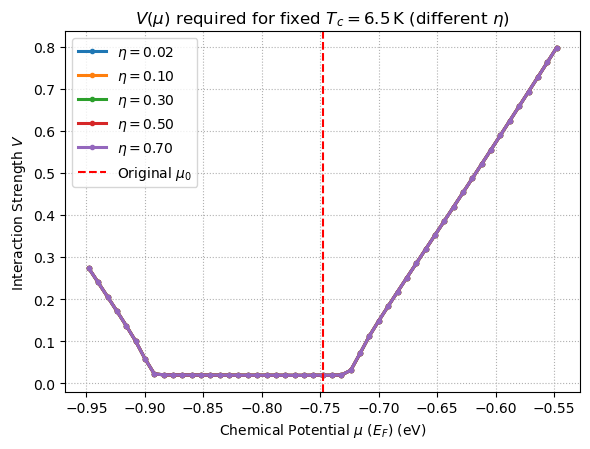


--- All calculations complete ---


In [26]:
# ------------------------ Calculate V(mu) for fixed Tc ------------------------

# Set fixed parameters
Tc_fixed_K = 6.5  # Fixed Critical Temperature
Nw = 800          # Matsubara frequencies
n_keep = 1200     # FS sample size per valley

# Set fixed SOI parameters (using the 13 meV case from the paper)
target_meV_fixed = 13.0
beta_fixed = beta_from_target(target_meV_fixed)

# Define the g-functions with this fixed beta
gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_fixed: gR_vec(kx, ky, fK, b)

# The Zeeman-type coupling strength is fixed
alpha_Z_fixed = alpha

print(f"Using fixed Tc = {Tc_fixed_K} K")
print(f"Using fixed SOI g-function shapes for target_meV = {target_meV_fixed}")

# Define range of chemical potential (mu, i.e., E_F) to scan
# This is the original E_F = E_K_raw + 0.15
EF_center = E_F 
EF_scan_range = 0.2   # Scan range in eV
N_mu_points = 51      # Number of points in the scan
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
print(f"Scanning mu (E_F) from {EF_range[0]:.3f} eV to {EF_range[-1]:.3f} eV")

# Define eta list and initialize plot
#eta_list = [0.00, 0.02, 0.06, 0.10]
eta_list = [0.02, 0.1, 0.3, 0.5, 0.7]

plt.figure(figsize=(6, 4.6))

# Loop over eta, and for each, scan V(mu)
for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")
    
    # Set the Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed
    
    V_results_for_this_eta = []
    
    # Scan over the E_F range
    desc = f"  Scanning V(mu) (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        
        # Re-build FS shell for this E_F value
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, n_keep=n_keep)
        
        # Calculate V needed for Tc=6.5K at this EF_val and eta
        # (This call uses the correct signature for determine_V)
        V_new = determine_V(Tc_fixed_K, alpha_Z_fixed, alpha_R_current,
                            gz_fun_fixed, gR_fun_fixed,
                            kK_new, mu_guess, EF_val, Nw)
        
        V_results_for_this_eta.append(V_new)

    # Plot this eta's curve
    plt.plot(EF_range, V_results_for_this_eta, lw=2.2, 
             marker='o', markersize=3, 
             label=rf'$\eta={eta:.2f}$')

# Finalize and show the plot
plt.xlabel(r'Chemical Potential $\mu$ ($E_F$) (eV)')
plt.ylabel(r'Interaction Strength $V$')
plt.title(r'$V(\mu)$ required for fixed $T_c = 6.5\,$K (different $\eta$)')
# Add a vertical line at the original E_F
plt.axvline(EF_center, color='red', ls='--', label=f'Original $\mu_0$')
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- All calculations complete ---")